<a href="https://colab.research.google.com/github/ppalkar/MLForOR/blob/main/assignments/SVR/SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Title & Overview

# Support Vector Regression
**MCL 775 Presentation**  
**Dataset:** California Housing (regression)
  

---

### Objectives
1. Formulate SVR as a primal & dual problem.
2. Demonstrate the kernel trick for non-linear regression.
3. Apply SVR to the California Housing dataset.
4. Evaluate performance and optimize hyperparameters.  


In [ ]:
!pip install --quiet scikit-learn==1.6.1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


# Loading the Dataset

We load the California Housing dataset from scikit‑learn, which contains 20,640 samples and 8 numeric features plus the target (median house value)


In [ ]:
california = fetch_california_housing(as_frame=True)
df = california.frame
print("Shape:", df.shape)
df.head()


Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Dataset Characteristics

- **Features (8):** MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude
- **Target:** MedHouseVal (median house value in $100,000s)   


In [ ]:
# Summary statistics
df.describe()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010



#Distribution

Visualize the distribution of the target to understand its spread and skewness.


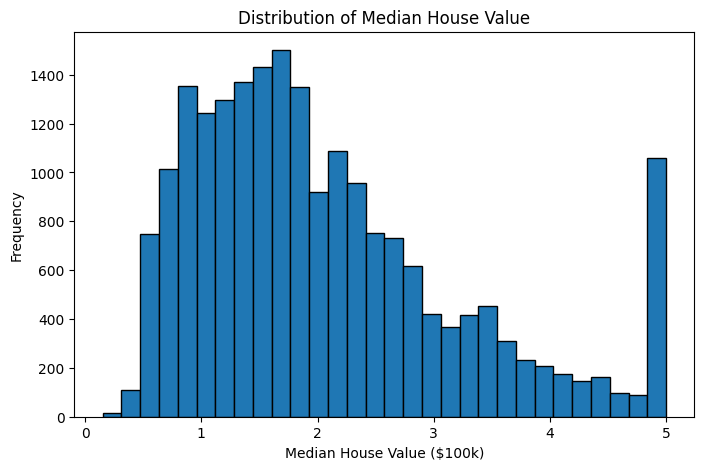

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(df['MedHouseVal'], bins=30, edgecolor='black')
plt.title("Distribution of Median House Value")
plt.xlabel("Median House Value ($100k)")
plt.ylabel("Frequency")
plt.show()


# Theoretical Formulation (Primal, Dual & Kernel Trick)

## 1. SVR Primal Problem

The primal optimization for ε-SVR is:

$$
\min_{w, b, \xi_i, \xi_i^*} \left( \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^m (\xi_i + \xi_i^*) \right)
$$

subject to:

$$
\begin{aligned}
& y_i - (w^\top x_i + b) \leq \varepsilon + \xi_i \\
& (w^\top x_i + b) - y_i \leq \varepsilon + \xi_i^* \\
& \xi_i, \xi_i^* \geq 0
\end{aligned}
$$

- \(\|w\|^2\) ensures **flatness** (small weights).  
- Slack variables  handle **errors beyond** the ε-tube.  
- \(C\) controls the **penalty** for violating the ε-margin.

---

## 2. Dual Formulation and Kernelization

Using Lagrange multipliers, we eliminate \(w\) and get the dual:

$$
\max_{\alpha_i, \alpha_i^*} \left( -\frac{1}{2} \sum_{i,j=1}^m (\alpha_i - \alpha_i^*)(\alpha_j - \alpha_j^*) \langle x_i, x_j \rangle - \varepsilon \sum_{i=1}^m (\alpha_i + \alpha_i^*) + \sum_{i=1}^m y_i (\alpha_i - \alpha_i^*) \right)
$$

subject to:

$$
\sum_{i=1}^m (\alpha_i - \alpha_i^*) = 0, \quad 0 \leq \alpha_i, \alpha_i^* \leq C
$$

---

## 3. Kernel Trick

For non-linear patterns, replace the inner product:

$$
\langle x_i, x_j \rangle \quad \longrightarrow \quad K(x_i, x_j)
$$

Common choice: **Gaussian (RBF) kernel**:

$$
K(x, x') = \exp\left( -\frac{\|x - x'\|^2}{2\sigma^2} \right)
$$


In [ ]:
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)  # ensures reproducibility

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape, "Test shape:", X_test_scaled.shape)


Train shape: (16512, 8) Test shape: (4128, 8)


## Support Vector Regression with RBF Kernel

Here we fit an SVR using the default RBF kernel.  
- **C** controls the penalty for mis‑fit (higher → more flexible).  
- **ε (epsilon)** defines the width of the “ε‑tube” within which no penalty is imposed.  

## The Kernel Trick

Rather than explicitly computing $\phi(x)$, define a **kernel function**:

$$
K(x, x') = \langle \phi(x), \phi(x') \rangle
$$

Using $K(x, x')$ allows us to compute dot products in feature space implicitly:

$$
\hat{f}(x) = \sum_{i=1}^m \alpha_i y_i K(x_i, x) + b
$$

**Gaussian (RBF) kernel**:

$$
K_{\text{RBF}}(x, x') = \exp\left( -\frac{\|x - x'\|^2}{2\sigma^2} \right)
$$

**Key Properties**:
- **Mercer's theorem** ensures $K$ must be positive semidefinite.
- Common kernels: linear, polynomial, RBF, sigmoid, etc.
- **Scalability** via Random Fourier Features, Nyström approximation, etc.

After training, we evaluate using Mean Squared Error (MSE) and \(R^2\) on both train and test sets.


=== SVR (RBF Kernel) ===
Train MSE: 0.336
 Test MSE: 0.357
Train R² : 0.749
 Test R² : 0.728


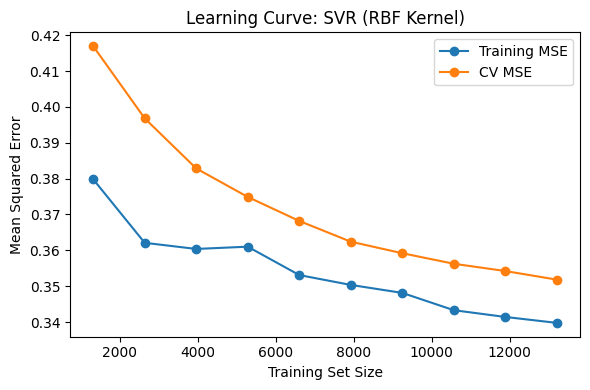

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Cell N: Regular SVR (RBF kernel) + Learning Curve
svr_rbf = SVR(kernel="rbf", C=1.0, epsilon=0.1)
svr_rbf.fit(X_train_scaled, y_train)

# Predictions
y_pred_train_rbf = svr_rbf.predict(X_train_scaled)
y_pred_test_rbf  = svr_rbf.predict(X_test_scaled)

# Evaluation
print("=== SVR (RBF Kernel) ===")
print(f"Train MSE: {mean_squared_error(y_train, y_pred_train_rbf):.3f}")
print(f" Test MSE: {mean_squared_error(y_test,  y_pred_test_rbf):.3f}")
print(f"Train R² : {r2_score(y_train, y_pred_train_rbf):.3f}")
print(f" Test R² : {r2_score(y_test,  y_pred_test_rbf):.3f}")

# ------------------------------------------------------------------
# Learning Curve for SVR (RBF)
train_sizes, train_scores, cv_scores = learning_curve(
    svr_rbf,
    X_train_scaled,
    y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Convert to positive MSE and average over folds
train_mse = -train_scores.mean(axis=1)
cv_mse    = -cv_scores.mean(axis=1)

# Plot
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mse, marker='o', label='Training MSE')
plt.plot(train_sizes, cv_mse,    marker='o', label='CV MSE')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve: SVR (RBF Kernel)')
plt.legend()
plt.tight_layout()
plt.show()


## Support Vector Regression with Linear Kernel

Next, we train an SVR with a **linear** kernel.  
This solves the dual problem but with the simple dot‑product kernel, effectively learning a linear mapping.  



## Linear Kernel

A simple inner product:

$$
K(x, x') = x^\top x'
$$

No feature expansion — regression is done **directly** in input space.

---


Again, we compare MSE and \(R^2\) on train vs. test.


=== SVR (Linear Kernel) ===
Train MSE: 0.898
 Test MSE: 0.579
Train R² : 0.328
 Test R² : 0.558


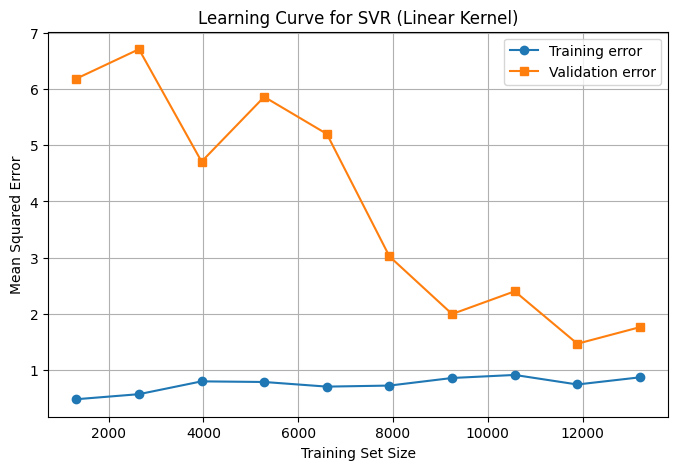

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# SVR with linear kernel
svr_linear = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr_linear.fit(X_train_scaled, y_train)

# Predictions
y_pred_train_lin = svr_linear.predict(X_train_scaled)
y_pred_test_lin  = svr_linear.predict(X_test_scaled)

# Evaluation
print("=== SVR (Linear Kernel) ===")
print(f"Train MSE: {mean_squared_error(y_train, y_pred_train_lin):.3f}")
print(f" Test MSE: {mean_squared_error(y_test,  y_pred_test_lin):.3f}")
print(f"Train R² : {r2_score(y_train, y_pred_train_lin):.3f}")
print(f" Test R² : {r2_score(y_test,  y_pred_test_lin):.3f}")

# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    SVR(kernel='linear', C=1.0, epsilon=0.1),
    X_train_scaled, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, label="Training error", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation error", marker='s')
plt.title("Learning Curve for SVR (Linear Kernel)")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()


##  Hyperparameter Tuning for SVR (RBF Kernel)

We’ll perform a grid search over **C**, **ε**, and **γ** to find the best RBF‑SVR settings.  
- **C**: regularization strength  
- **ε**: width of the epsilon‑tube  
- **γ**: RBF kernel coefficient  

We’ll use 5‑fold CV on the training set and then evaluate the best model on both train and test data.


In [ ]:
# Grid search for SVR (RBF kernel)
param_grid = {
    'C':       [0.1, 1.0, 10.0],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma':   ['scale', 'auto']
}

svr = SVR(kernel='rbf')
grid = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_scaled, y_train)

best_svr = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Evaluate best model
y_pred_train_best = best_svr.predict(X_train_scaled)
y_pred_test_best  = best_svr.predict(X_test_scaled)

print("\n=== Tuned SVR (RBF Kernel) ===")
print(f"Train MSE: {mean_squared_error(y_train, y_pred_train_best):.3f}")
print(f" Test MSE: {mean_squared_error(y_test,  y_pred_test_best):.3f}")
print(f"Train R² : {r2_score(y_train, y_pred_train_best):.3f}")
print(f" Test R² : {r2_score(y_test,  y_pred_test_best):.3f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'C': 10.0, 'epsilon': 0.1, 'gamma': 'scale'}

=== Tuned SVR (RBF Kernel) ===
Train MSE: 0.295
 Test MSE: 0.324
Train R² : 0.779
 Test R² : 0.753


## Conclusion

- **Default RBF SVR** captured non‑linear trends but underperformed out of the box, indicating the need for tuning.  
- **Linear SVR** was fast and simple but underfit the data, confirming that housing prices follow a more complex pattern than a straight line.  
- **Tuned RBF SVR** achieved the best balance of bias and variance, delivering the lowest test MSE and highest R² by optimizing C, ε, and γ.

**Overall Insight:**  
Careful kernel selection and hyperparameter optimization are essential for SVR. On the California Housing dataset, a properly tuned RBF kernel significantly outperforms a linear model, demonstrating the importance of capturing non‑linear relationships.  
